# PS3#05 - Neural networks for classification

<div style="text-align: right;font-size: 0.8em">Last updated: 2022-12-08</div>

This notebook requires `torch`, `numpy`, and `matplotlib` to run. If the following cell raises an error, install them first.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

np.random.seed(0)

The following function generate a data set with $3$ classes:

In [2]:
def generate_dataset(N1, N2, N3):
    inf_1 = -1
    sup_1 = 1
    inf_2 = 0.2
    sup_2 = 1
    inf_3 = -1
    sup_3 = -0.2

    var = 0.15

    def mean_11(x):
        return 1.2*np.abs(x) + 0.2
    def mean_12(x):
        return - mean_11(x)
    
    def mean_21(x):
        return np.abs(x-0.2)
    def mean_22(x):
        return - mean_21(x)
    
    def mean_31(x):
        return np.abs(x + 0.2)
    def mean_32(x):
        return -np.abs(x + 0.2)

    N = N1+N2+N3
    X = np.zeros((N, 2), float)
    X[:N1, 0] = np.random.uniform(low=inf_1, high=sup_1, size=N1)
    X[N1:N1+N2, 0] = np.random.uniform(low=inf_2, high=sup_2, size=N2)
    X[N1+N2:, 0] = np.random.uniform(low=inf_3, high=sup_3, size=N3)
    for n, m, mean1, mean2, in (
        (0, N1, mean_11, mean_12), 
        (N1, N1+N2, mean_21, mean_22), 
        (N1+N2, N, mean_31, mean_32)
    ):
        m_ = n + (m-n)//2
        X[n:m_, 1] = mean1(X[n:m_, 0]) + np.random.normal(0, var, size=m_-n)
        X[m_:m, 1] = mean2(X[m_:m, 0]) + np.random.normal(0, var, size=m-m_)
    Y = np.zeros(N, int)
    Y[N1:N1+N2] = 1
    Y[N1+N2:] = 2

    permutation = np.random.permutation(N)
    X = X[permutation]
    Y = Y[permutation]

    return X, Y


We generate $2000$ training points, and plot the resulting data set:

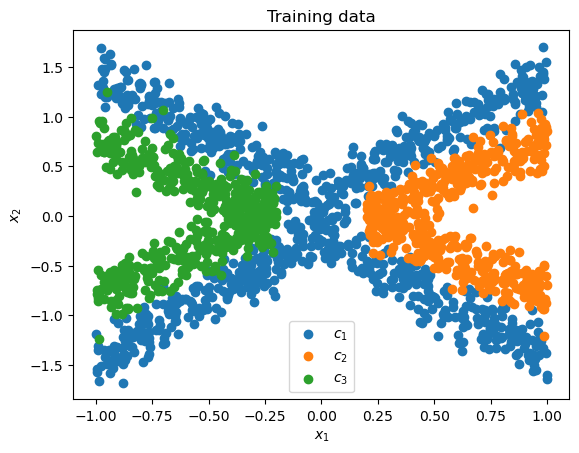

In [3]:
X_train, Y_train = generate_dataset(1000, 500, 500)

def plot_data(X, Y):
    plt.scatter(X[Y==0, 0], X[Y==0, 1], label=r'$c_1$')
    plt.scatter(X[Y==1, 0], X[Y==1, 1], label=r'$c_2$')
    plt.scatter(X[Y==2, 0], X[Y==2, 1], label=r'$c_3$')
    plt.legend(loc='best')
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")

plot_data(X_train, Y_train)
plt.title("Training data")
plt.show()

Pytorch provides powerful utilities to handle data in the module `torch.utils.data`. Important examples are the `Dataset` and `DataLoader` classes.
The first one is used to centralize data management in a single object, and the second one is used to load data in batches of specific size for training.

A good practice is thus to define a subclass of `Dataset`, and to feed the resulting object in a `DataLoader` object.

In [4]:
class MyDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray) -> None:
        # Store X and Y as attributes
        # You need to convert them to torch.Tensor
        # X should have data type float
        ### BEGIN SOLUTION
        self.X = torch.tensor(X).float()
        self.Y = torch.tensor(Y)
        ### END SOLUTION

    def __getitem__(self, index):
        # Return a tuple consisting of a pair (x, y)
        # where x (resp. y) is the element of X (resp Y)
        # with index `index`
        ### BEGIN SOLUTION
        return self.X[index], self.Y[index]
        ### END SOLUTION

    def __len__(self):
        # Return the total number of data points
        ### BEGIN SOLUTION
        return len(self.X)
        ### END SOLUTION

data_train = MyDataset(X_train, Y_train)

train_loader = DataLoader(data_train, batch_size=64)


It is now time to define our model.
We need at least one hidden layer, since the data is not linearly separable.
Fill in the `MulticlassClassifier` class so it meets the following constraints:
* The network has exactly one hidden layer, which has `n_hidden` neurons;
* Use tanh activation for this hidden layer;
* The network accepts as input a pair $(x_1, x_2)$ of the data set defined previously;
* The network has $3$ output neurons and a softmax activation on the last layer. Each neuron computes the probability for the input to belong to the corresponding class.

**Remark** You should **not** add the softmax layer in the network directly, but leave the last layer without activation. The softmax is automatically added by Pytorch's `nn.CrossEntropyLoss`, which we will use later.

In [5]:
class MulticlassClassifier(nn.Module):
    def __init__(self, n_hidden: int):
        """
        Initialize the network
        Args:
            n_hidden: the number of neurons of the hidden layer
        """
        super().__init__()
        ### BEGIN SOLUTION
        self.l1 = nn.Linear(2, n_hidden)
        # The output layer has 3 neurons since we have 3 classes
        self.l2 = nn.Linear(n_hidden, 3)
        self.tanh = nn.Tanh()
        ### END SOLUTION
    
    def forward(self, x):
        """
        Perform the forward pass
        """
        ### BEGIN SOLUTION
        x = self.l1(x)
        x = self.tanh(x)
        x = self.l2(x)
        # We do NOT add the softmax manually as Pytorch does it automatically
        # when selecting using nn.CrossEntropyLoss
        ### END SOLUTION
        return x

We propose to use a very simple network with simply $2$ neurons in the hidden layer. We use the Adam optimizer, which is an extension of minibatch gradient descent and popular choice in modern deep learning.

In [6]:
LEARNING_RATE = 0.1
model = MulticlassClassifier(n_hidden=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

MulticlassClassifier(
  (l1): Linear(in_features=2, out_features=2, bias=True)
  (l2): Linear(in_features=2, out_features=3, bias=True)
  (tanh): Tanh()
)


Before training, we implement a function that computes the accuracy of a batch of predictions:

In [7]:
def accuracy(logits: torch.Tensor, y_true: torch.Tensor) -> float:
    """
    Compute the accuracy of the prediction
    Args:
        logits: torch.Tensor of shape (B, 3), where B is the batch size
            Represents the activations of the last layer of the network 
            (before softmax)
        y_true: true labels, of shape (B,). Ordered in the same way as logits
    """
    ### BEGIN SOLUTION
    # log_softmax is numerically more stable than softmax, and does the same job
    log_probas = torch.log_softmax(logits, dim=1)
    _, y_pred = torch.max(log_probas, dim=1)

    acc = (y_pred == y_true).sum() / len(y_true)
    acc = torch.round(100 * acc)

    return acc
    ### END SOLUTION

We are now ready to train our model.
For this, we implement the **training loop**, that is, a `for` loop that iterates over the whole data set and takes the appropriate gradient steps.
One iteration of this loop is called an **epoch**.
In each epoch, we divide the data in **batches** that are handled separately, one after the other. We refer you to PS3, Problem 3 (Flavors of Gradient Descent) for a discussion of batches.

In [8]:
EPOCHS = 10
accuracies = []  # average accuracy during an epoch
losses = []  # average loss during an epoch

# Some layers (like Dropout or Batchnorm) behave differently 
# in train and evaluation modes.
# We do not have such layers in our simple network, but 
# setting the mode of the network manually is a good habit to take.
model.train()
for epoch in range(1, EPOCHS + 1):
    sum_epoch_loss = 0
    sum_epoch_acc = 0
    for X_train_batch, Y_train_batch in train_loader:
        # Pytorch does NOT reinitialize the gradients on its own
        # Calling this function is important, otherwise, the gradients
        # are summed across all training steps, which is nonsensical
        optimizer.zero_grad()

        # Store the loss and accuracy on the batch in these variables
        # to keep track of the training statistics
        train_loss = ...
        train_acc = ...

        # You should: 
        # 1. Use the model to predict the logits 
        # 2. Compute the loss and accuracy 
        # 3. Perform backproagation (train_loss.backward()) 
        # 4. Perform the optimizer step
        
        ### BEGIN SOLUTION
        # Output of the network (before softmax)
        logits = model(X_train_batch)

        # Compute the loss and accuracy
        train_loss = criterion(logits, Y_train_batch)
        train_acc = accuracy(logits, Y_train_batch)

        # Perform the backward pass
        train_loss.backward()
        # Perform an optimizer step
        # If optimizer = SGD, this is a gradient step
        # In general, optimizers do more complicated things, 
        # but the idea is similar
        optimizer.step()
        ### END SOLUTION

        # We keep track of training statistics
        sum_epoch_loss += train_loss.item()
        sum_epoch_acc += train_acc.item()
    accuracies.append(sum_epoch_acc / len(train_loader))
    losses.append(sum_epoch_loss / len(train_loader))
    print(f'Epoch: {epoch} | Loss: {losses[-1]:.5f} | Accuracy: {accuracies[-1]:.5f}')


Epoch: 1 | Loss: 0.80903 | Accuracy: 51.75000
Epoch: 2 | Loss: 0.42236 | Accuracy: 86.25000
Epoch: 3 | Loss: 0.19191 | Accuracy: 95.53125
Epoch: 4 | Loss: 0.13980 | Accuracy: 95.81250
Epoch: 5 | Loss: 0.12441 | Accuracy: 95.78125
Epoch: 6 | Loss: 0.11738 | Accuracy: 95.75000
Epoch: 7 | Loss: 0.11365 | Accuracy: 95.81250
Epoch: 8 | Loss: 0.11148 | Accuracy: 95.84375
Epoch: 9 | Loss: 0.11014 | Accuracy: 95.87500
Epoch: 10 | Loss: 0.10929 | Accuracy: 95.87500


Our network is now trained. We can evaluate its **decision boundary** by computing its prediction on a dense grid and coloring the regions with the same prediction:

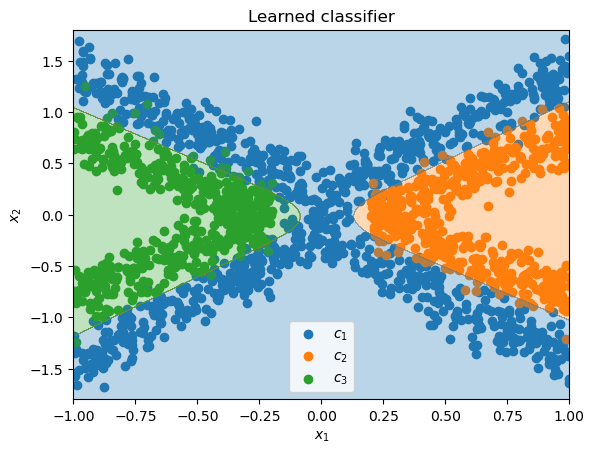

In [9]:
plot_data(X_train, Y_train)

N_grid = 1000
X_plot = np.dstack(np.meshgrid(np.linspace(-1, 1, N_grid), np.linspace(-1.8, 1.8, N_grid)))
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_plot.reshape(-1, 2)).float())
    _, Y_plot = torch.max(logits, dim=1)
    Y_plot = Y_plot.numpy().reshape(N_grid, N_grid)
cmap = colors.ListedColormap(['tab:blue','tab:orange','tab:green'])
plt.contourf(X_plot[:, :, 0], X_plot[:, :, 1], Y_plot, cmap=cmap, alpha=0.3)
plt.legend(loc='lower center')
_=plt.title('Learned classifier')

The learned classifier looks excellent!